In [1]:
import importlib
import read_data
import Anomaly
import pandas as pd

# =============================
# Load mPower data with eGeMAPS features 
# =============================

In [2]:
# Reload custom functions to reflect changes during runtime
importlib.reload(read_data)
# Load preprocessed mPower dataset with eGeMAPS features
data = read_data.read_mPower16knorm_eGeMAPS()
# Drop the 'medTimepoint' column as it's not needed for further analysis
data = data.drop(['medTimepoint'], axis=1)

In [3]:
# Import filtering function
import Filter_record
importlib.reload(Filter_record)
# Apply filtering: Remove frequent recordings (keep only between 1 and 30 recordings per subject)
filt_data = Filter_record.rec(data, 1, 30)

# Import data printing function
# Print original and filtered data
import Print_data
importlib.reload(Print_data)
print('All data')
Print_data.printdata(data)
print('\n')
print('Filtered data: Removed frequent recordings')
Print_data.printdata(filt_data)

Filtered data size : (30440, 92)
All data
Total Size: 62963, Subject Size: 4989
HC - Sample Size: 23279, Subject Size: 3952
PD - Sample Size: 39308, Subject Size: 965
HC Female - Sample Size: 4233, Subject Size: 747
HC Male - Sample Size: 19046, Subject Size: 3205
PD Female - Sample Size: 18284, Subject Size: 336
PD Male - Sample Size: 21024, Subject Size: 629


Filtered data: Removed frequent recordings
Total Size: 30440, Subject Size: 3969
HC - Sample Size: 17673, Subject Size: 3048
PD - Sample Size: 12453, Subject Size: 863
HC Female - Sample Size: 3488, Subject Size: 578
HC Male - Sample Size: 14185, Subject Size: 2470
PD Female - Sample Size: 4865, Subject Size: 307
PD Male - Sample Size: 7588, Subject Size: 556


In [ ]:
# Import age and gender grouping custom function
import Group_age_gender
importlib.reload(Group_age_gender)
# Split data into three age groups: Young (<35), Mid (35-55), Old (>55)
data_young, data_mid, data_old = Group_age_gender.age3(filt_data, 35, 55)

In [5]:
# Import train-test splitting function
import Train_Test
importlib.reload(Train_Test)
# Perform train-test split for each age group
print('Young')
data_train_young, data_test_young = Train_Test.split_and_print2(data_young)

print('Mid')
data_train_mid, data_test_mid = Train_Test.split_and_print2(data_mid)

print('Old')
data_train_old, data_test_old = Train_Test.split_and_print2(data_old)

Young
  Set Condition Gender  Sample Size  Subject Size
Train        HC Female         1259           241
Train        HC   Male         5620          1160
Train        PD Female            8             2
Train        PD   Male           49            12
 Test        HC Female          662           129
 Test        HC   Male         2226           473
 Test        PD Female            2             1
 Test        PD   Male           14             4
Mid
  Set Condition Gender  Sample Size  Subject Size
Train        HC Female          742            98
Train        HC   Male         2835           436
Train        PD Female          411            41
Train        PD   Male         1060            92
 Test        HC Female          256            45
 Test        HC   Male         1178           175
 Test        PD Female          239            21
 Test        PD   Male          593            45
Old
  Set Condition Gender  Sample Size  Subject Size
Train        HC Female          452 

# =============================
# Anomaly Detection and Cleaning
# =============================

In [6]:
# Anomaly detection
importlib.reload(Anomaly)
# Combine training and test sets across age groups
data_train = pd.concat([data_train_young, data_train_mid, data_train_old])
data_test = pd.concat([data_test_young, data_test_mid, data_test_old])
# Detect and remove anomalies from training and test data
data_train, anomaly_model = Anomaly.anomaly_all(data_train, 0)
data_test = Anomaly.anomaly_test(data_test, anomaly_model, 0)

Data removed total: 345 out of 20965
Total data: 20965
Clean data: 20620
Data removed total: 178 out of 9161
Total data: 9161
Clean data: 8983


In [ ]:
importlib.reload(Group_age_gender)
# Group data after anomaly removal
data_train_young, data_train_mid, data_train_old = Group_age_gender.age3(data_train, 35, 55)

data_test_young, data_test_mid, data_test_old = Group_age_gender.age3(data_test, 35, 55)

# =============================
# Resampling Data
# =============================

In [8]:
import Resample
importlib.reload(Resample)
data_train_young_rs = Resample.resample_subgroups(data_train_young)
data_train_mid_rs = Resample.resample_subgroups(data_train_mid)
data_train_old_rs = Resample.resample_subgroups(data_train_old)


Minimum size: 4.0, Second minimum size: 46

Resampled Data Summary:
+---------------+----------+-------------------------+--------------------------+
| Condition     | Gender   |   Resampled Sample Size |   Resampled Subject Size |
+===============+==========+=========================+==========================+
| Condition 0.0 | Female   |                      46 |                       40 |
+---------------+----------+-------------------------+--------------------------+
| Condition 0.0 | Male     |                      46 |                       44 |
+---------------+----------+-------------------------+--------------------------+
| Condition 1.0 | Female   |                      46 |                        1 |
+---------------+----------+-------------------------+--------------------------+
| Condition 1.0 | Male     |                      46 |                       12 |
+---------------+----------+-------------------------+--------------------------+
Minimum size: 381.0, Second mi

# =============================
# Feature Scaling using GWS
# =============================

In [9]:
import GWS
importlib.reload(GWS)

data_train_young_s, data_test_young_s, scaler_young_f, scaler_young_m = GWS.gws(data_train_young_rs, data_train_young, data_test_young)

data_train_mid_s, data_test_mid_s, scaler_mid_f, scaler_mid_m = GWS.gws(data_train_mid_rs, data_train_mid, data_test_mid)

data_train_old_s, data_test_old_s, scaler_old_f, scaler_old_m = GWS.gws(data_train_old_rs, data_train_old, data_test_old)


In [10]:
# Merge processed training and test data
data_train_s = pd.concat([data_train_young_s, data_train_mid_s, data_train_old_s])
data_train_s.columns = data_train_s.columns.str.replace('[<>\[\]]', '_', regex=True)
data_test_s = pd.concat([data_test_young_s, data_test_mid_s, data_test_old_s])
data_test_s.columns = data_test_s.columns.str.replace('[<>\[\]]', '_', regex=True)

In [11]:
from sklearn.model_selection import GroupShuffleSplit
from xgboost import XGBClassifier
modelxgb = XGBClassifier(eval_metric='mlogloss')

x_train = data_train_s.drop([ 'age', 'healthcode', 'y', 'age_range', 'gender'], axis=1)
y_train = data_train_s['y']
x_test = data_test_s.drop(['age', 'healthcode', 'y', 'age_range', 'gender'], axis=1)
y_test = data_test_s['y']
healthcode_train = data_train_s['healthcode']

modelxgb.fit(x_train, y_train)
print('Accuracy of XGB classifier on training set: {:.4f}'.format(modelxgb.score(x_train, y_train)))

Accuracy of XGB classifier on training set: 0.9778


# =============================
# Recursive Feature Elimination CV (RFECV)
# =============================

In [ ]:
import RFECV_Func
importlib.reload(RFECV_Func)
best_features = RFECV_Func.rfecv_sel(x_train, y_train, healthcode_train, modelxgb, "eGeMAPS")

In [133]:
print(best_features)

Index(['F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'spectralFluxUV_sma3nz_amean', 'VoicedSegmentsPerSec',
       'MeanVoicedSegmentLengthSec', 'StddevVoicedSegmentLengthSec',
       'StddevUnvoicedSegmentLength'],
      dtype='object')


In [13]:
best_features =['F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'spectralFluxUV_sma3nz_amean', 'VoicedSegmentsPerSec',
       'MeanVoicedSegmentLengthSec', 'StddevVoicedSegmentLengthSec',
       'StddevUnvoicedSegmentLength']

# =============================
# Model Training with Selected Features
# =============================

In [ ]:
model_rfe = XGBClassifier(eval_metric='mlogloss')
x_train_rfe = x_train[best_features]
data_test_meta = data_test_s[['age', 'healthcode', 'y', 'age_range', 'gender']]
x_test_rfe = data_test_s[best_features]
data_test_rfe = pd.concat([x_test_rfe, data_test_meta], axis=1)
model_rfe.fit(x_train_rfe, y_train)

# Finetuning

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': range(20, 101, 10),
    'max_depth': range(2, 8, 2)
}
cv2 = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_rfe, param_grid=param_grid, scoring='accuracy', cv=cv2, verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(x_train_rfe, y_train, groups=healthcode_train)

# Print the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy found: {grid_search.best_score_:.4f}")

# Use the best model found to make predictions
best_model = grid_search.best_estimator_

# =============================
# Model Evaluation
# =============================

# Test scores

In [41]:
import Evaluation
importlib.reload(Evaluation)

Evaluation.evaluate_model(best_model, data_test_rfe)

Accuracy: 0.7971
Precision: 0.7691
Recall: 0.7534
F1-score: 0.7612
ROC AUC: 0.8772
Specificity: 0.8300

Confusion Matrix:
      0     1
0  4173   855
1   932  2848

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      5028
           1       0.77      0.75      0.76      3780

    accuracy                           0.80      8808
   macro avg       0.79      0.79      0.79      8808
weighted avg       0.80      0.80      0.80      8808


# CV scores

In [160]:
import Evaluation
importlib.reload(Evaluation)

Evaluation.cv_scores(x_train_rfe,y_train, healthcode_train, best_model)

accuracy: 0.8121 (+/- 0.0116)
precision: 0.7320 (+/- 0.0214)
recall: 0.7564 (+/- 0.0386)
f1: 0.7431 (+/- 0.0172)
roc_auc: 0.8784 (+/- 0.0081)
specificity: 0.8433 (+/- 0.0173)


# ROC Curve

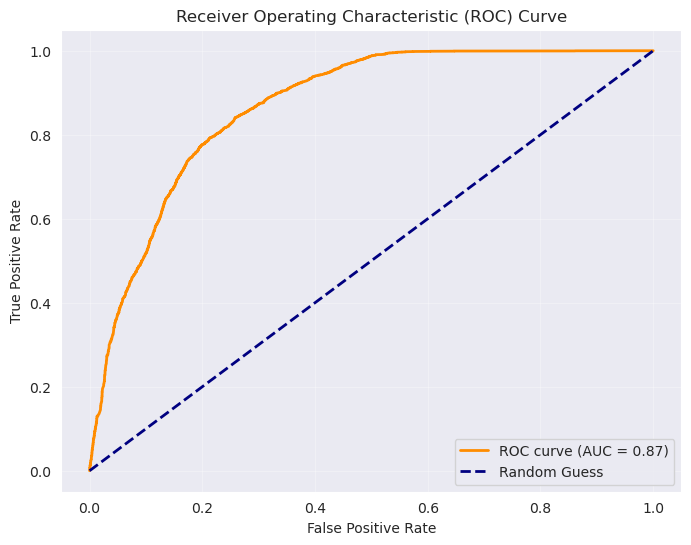

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

x_test22 = data_test_rfe.drop(['age', 'healthcode', 'y', 'age_range', 'gender'], axis=1)
y_test22 = data_test_rfe['y']

# Predict on test set
y_pred_prob22 = best_model.predict_proba(x_test22)[:, 1]
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test22, y_pred_prob22)
roc_auc = auc(fpr, tpr)
import pickle

# Save the variables to a file
with open("roc_data_mpower_egemaps.pkl", "wb") as file:
    pickle.dump({"y_test": y_test22, "y_prob": y_pred_prob22, "fpr": fpr, "tpr": tpr}, file)
# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# =============================
# Feature Importance using SHAP
# =============================

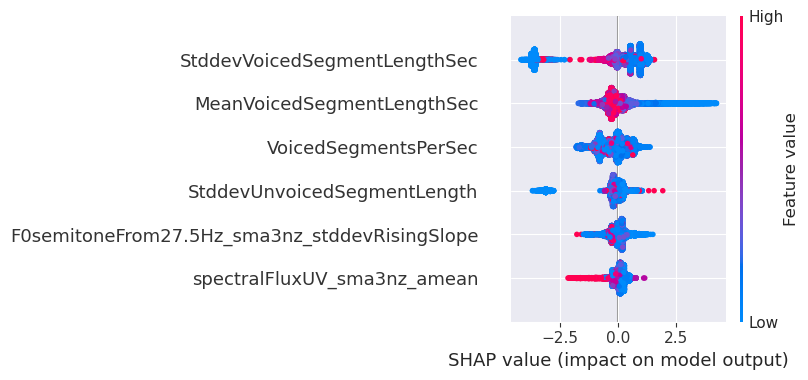

In [42]:
import SHap_Func
importlib.reload(SHap_Func)

shap_values = SHap_Func.shap_sum(x_train_rfe, best_model, "eGeMAPS")

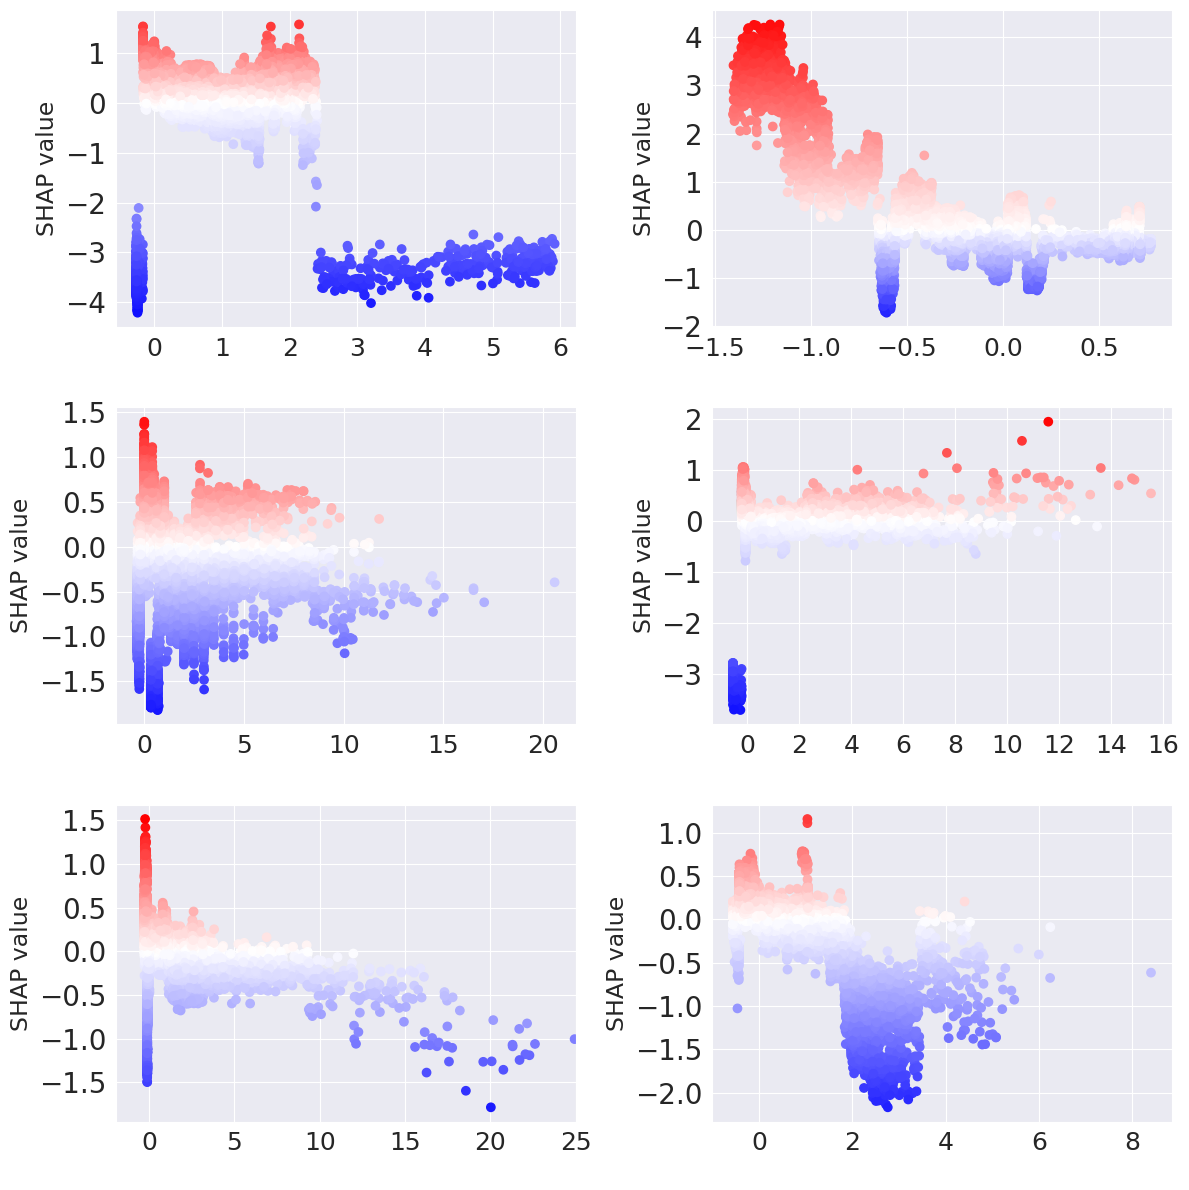

In [65]:
import SHap_Func
importlib.reload(SHap_Func)
# Calculate mean absolute SHAP values for each feature
shap_values_df = pd.DataFrame(shap_values, columns=x_train_rfe.columns)
mean_abs_shap_values = shap_values_df.abs().mean().sort_values(ascending=False)

# Get the top 10 features
features_dep = mean_abs_shap_values.head(6).index.tolist()
SHap_Func.shap_dep(x_train_rfe, features_dep ,shap_values, "eGeMAPS")